<a href="https://colab.research.google.com/github/gorkavarona/Malaria-Cassification-With-CNN/blob/master/MalariaFastAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine learning aplicado al diagnóstico y clasificación de la malaria mediante redes neuronales convolucionales.**
------------------------------------------------------------------------------
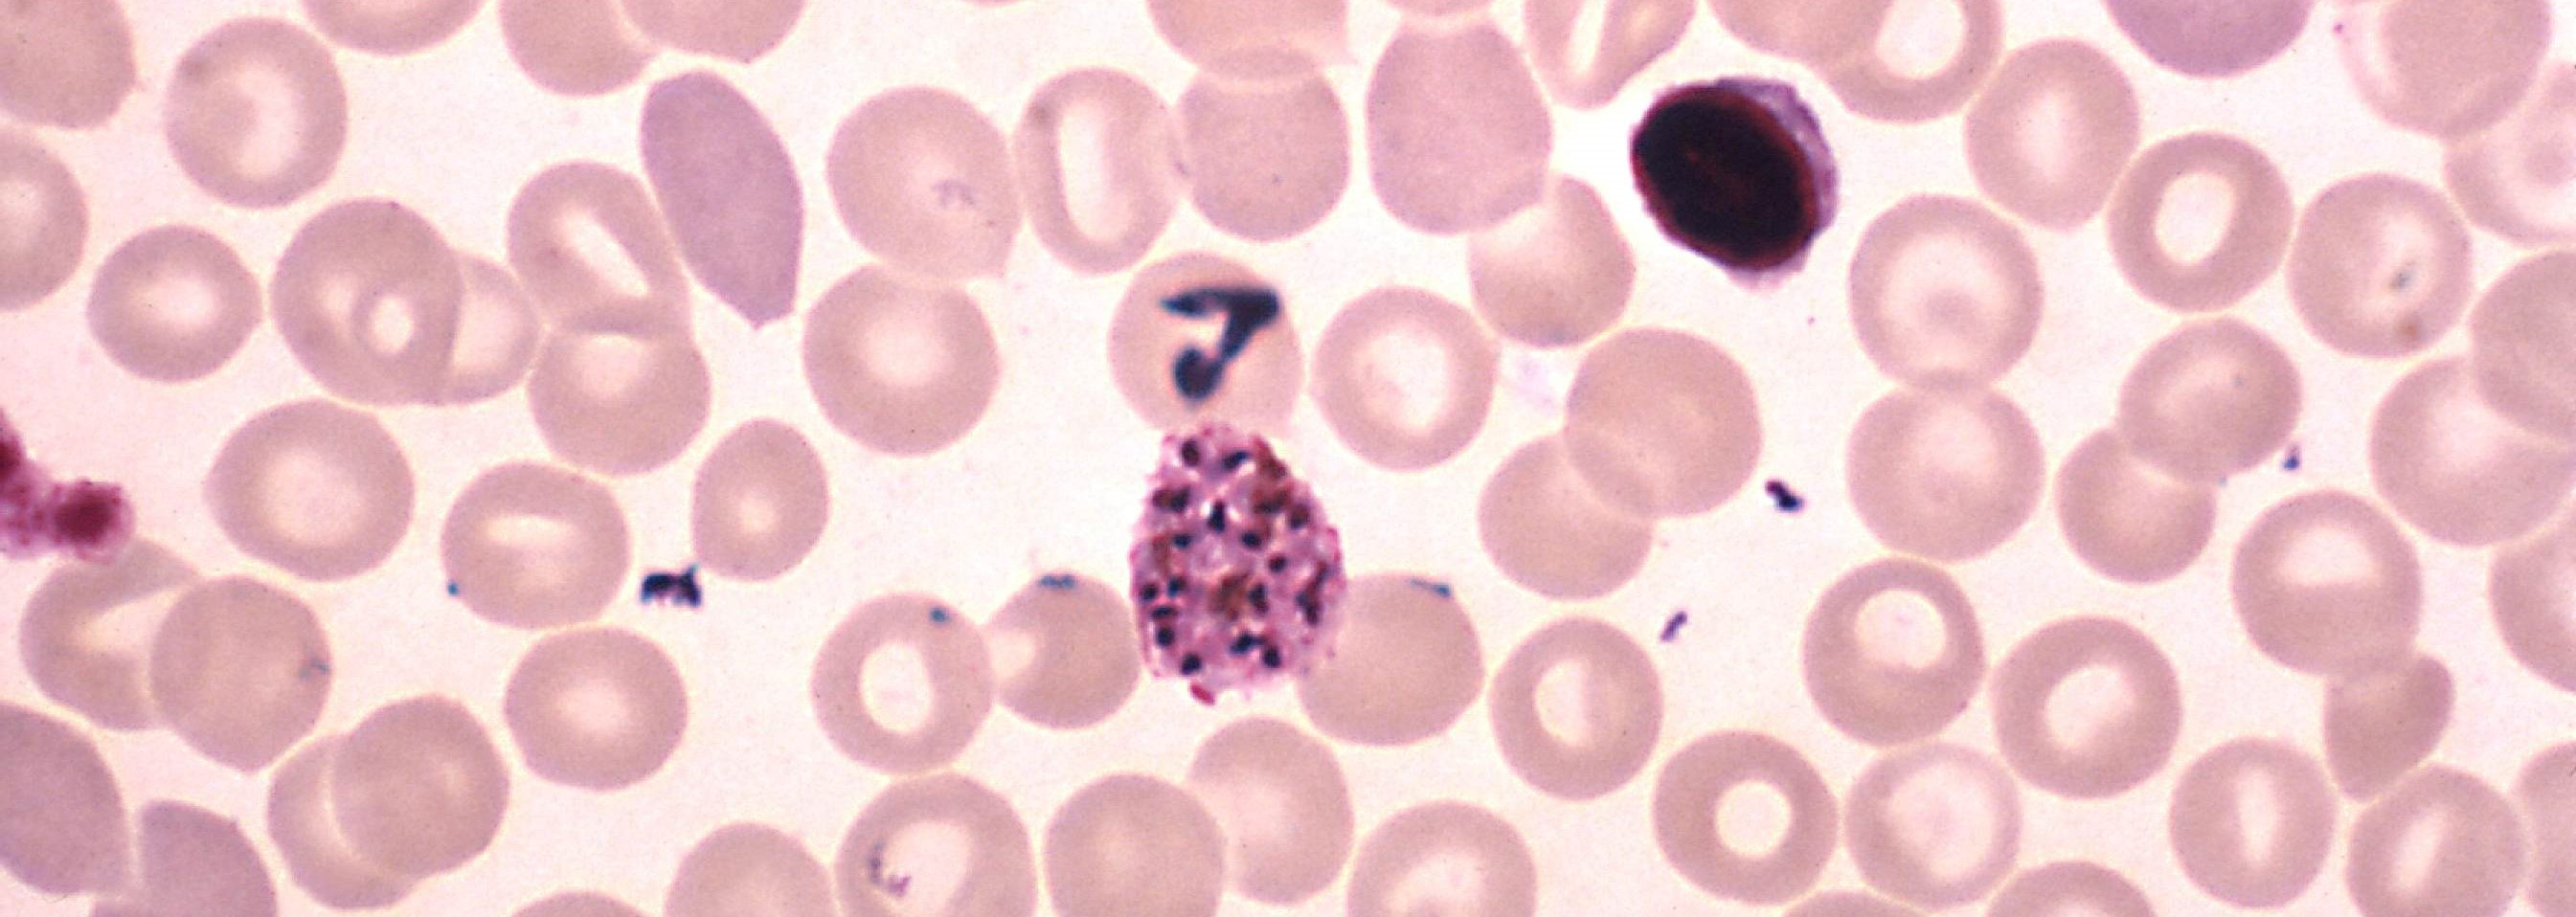

> **Acerca del proyecto**

*   **Autor:** Gorka Varona Garrido

*   **Tipo de proyecto:** Machine Learning + Redes Neuronales Convolucionales
*   **Bibliotecas utilizadas:**

    *   Numpy
    *   Pandas


*   **Set de datos:** Malaria Cell Image Dataset

*   **Fuente:** Mi github
*   **Origen:** https://lhncbc.nlm.nih.gov/LHC-downloads/downloads.html#malaria-datasets
*   **Última actualización:** 04/05/2021


> **Descripción**








Preparando el entorno de ejecución e instalando bibliotecas necesarias.

In [1]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
pip install fastai==2.0.19 fastcore==1.0.0

     |████████████████████████████████| 194kB 7.5MB/s 
     |████████████████████████████████| 5.9MB 10.7MB/s 
     |████████████████████████████████| 748.8MB 23kB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.6.0 which is incompatible.
ERROR: fastai 2.0.19 has requirement fastcore<1.4,>=1.3, but you'll have fastcore 1.0.0 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [3]:
pip install git+https://github.com/fastai/fastai2

  Cloning https://github.com/fastai/fastai2 to /tmp/pip-req-build-gmku1ntn
  Running command git clone -q https://github.com/fastai/fastai2 /tmp/pip-req-build-gmku1ntn
  Running command git submodule update --init --recursive -q
  Created wheel for fastai2: filename=fastai2-0.0.30-cp37-none-any.whl size=177979 sha256=d809c256fb840dcdee843913f2b6d5f178bfcdf1245adae3cab4aa7b1b7d4194
  Stored in directory: /tmp/pip-ephem-wheel-cache-bablend8/wheels/a1/59/9a/50335b36924b827e29d5f40b41fc3a008cc1f30dd80e560dfd
Successfully built fastai2


### **Paso 1. Importando las bibliotecas**

Se importan todas las librerias necesarias para la ejecución del código.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fastai2.data.all import *
from fastai2.vision.data import *
from fastai2.vision.all import *
from sklearn.metrics import auc, roc_curve, precision_recall_curve, classification_report

### **Paso 2. Obteniendo el conjunto de datos**

Obtenemos el conjunto de datos y lo preparamos para poder trabajar con el.

In [5]:
!git clone https://github.com/gorkavarona/Malaria-Cassification-With-CNN.git

Cloning into 'Malaria-Cassification-With-CNN'...
remote: Enumerating objects: 27574, done.
remote: Total 27574 (delta 0), reused 0 (delta 0), pack-reused 27574
Receiving objects: 100% (27574/27574), 331.64 MiB | 35.03 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (27561/27561), done.


In [7]:
print(os.listdir("Malaria-Cassification-With-CNN/dataset"))

['Uninfected', 'Parasitized']


In [8]:
path = Path('Malaria-Cassification-With-CNN/dataset/') 

### **Paso *3*. Preparando las imágenes**

Preparamos las variables que vamos a aplicar a las imágenes que después se pasarán al modelo.

1.   Dividimos los datos al azar con la función *RandomSplitter()*
2.   Aplicamos un cambio de tamaño (redimensionamiento) a cada elemento con *Resize* (224 tamaño común)
3.   Utilizamos *aug_transform* para la transformación de imágenes (voltearlas, zoom máximo y deformación máxima). Pasándole esto a *batch_tfms* hay que tener en  cuenta que las transformaciones sucederán en la GPU (si está disponible).



In [9]:
splitter = RandomSplitter()
item_tfms = [Resize(224)]
batch_tfms=[*aug_transforms(flip_vert=True,max_zoom=1.2, max_warp=0), Normalize.from_stats(*imagenet_stats)]

Creamos el bloque de datos, convirtiendo nuestros tipos en bloques (uno para imágenes y otro para categorias).  La función realiza la búsqueda de subcarpetas para todos los nombres de archivos de imágenes *get_image_files*. La division de entrenamiento y validación será realizada por la función *RandomSplitter()* y la función para obtener nuestros objetivos (a menudo llamados y) es parent_label.

In [10]:
data_block = DataBlock(blocks=[ImageBlock, CategoryBlock],
                  get_items=get_image_files,
                  get_y=parent_label,
                  splitter=splitter,
                  item_tfms=item_tfms,
                  batch_tfms=batch_tfms)

### **Paso 4. Alimentando el bloque de datos**

En sí mismo, el bloque de datos es solo un plano. No está haciendo nada (no busca errores). Para ello debemos alimentarlo con la fuente de los datos para recopilar algo utilizando *.dataloaders()* . Le pasaremos la ruta con las carpetas de 'Parasitized' y 'Uninfected' y bs=64 (tamaño de lote predeterminado, pero se podría aumentar o disminuir en función de la GPU). Después lo mostramos con *show_batch()*.



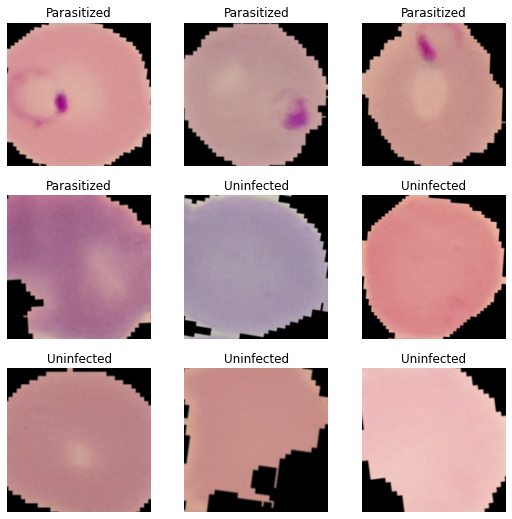

In [11]:
data = data_block.dataloaders(path, bs=64)
data.show_batch()

### **Paso *5*. Entrenando el modelo con CNN**

Entrenaremos nuestro modelo a través de las redes neuronales convolucionales con *cnn_learner()*. 

#### **Paso 5.1. Probando el modelo XResNet34**
Resnet34 es uno de esos modelos entrenados en el conjunto de datos ImageNet que contiene alrededor de 1.3 millones de imágenes y se puede clasificar en miles de categorías de imágenes. En nuestro problema, solo tenemos 2 categorías (infectado o no infectado), por lo que usamos las capas iniciales que son útiles para reconocer patrones básicos como líneas, esquinas, formas simples y luego volver a entrenar en las capas finales.

Con la métrica mediremos la calidad de las predicciones del modelo. Se utilizará la métrica 'accuracy' ya que esta mide el porcentaje de casos que el modelo ha acertado.

In [12]:
learn = cnn_learner(data, xresnet34, metrics=[accuracy])

Downloading: "https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth" to /root/.cache/torch/hub/checkpoints/xrn50_940.pth


Usamos la función *fine_tune()* ya que realiza la tarea de ajustar el modelo previamente entrenado para resolver nuestro problema específico utilizando los datos que hemos seleccionado.

In [13]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.369485,0.246172,0.912176,1:57:10


epoch,train_loss,valid_loss,accuracy,time
0,0.222766,0.158496,0.946289,2:36:05
1,0.193914,0.135142,0.954273,2:32:02
2,0.174522,0.127074,0.957358,2:32:14


Guardamos el modelo ya entrenado y ajustado en la carpeta creeada por defecto.

In [14]:
learn.save('stage-1')

### **Paso 6. Creando la matriz de confusión**

Utilizaremos la función *ClassificationInterpretation* para interpretar mejor las predicciones del modelo. Después dibujamos el cuadro de matriz de confusión.

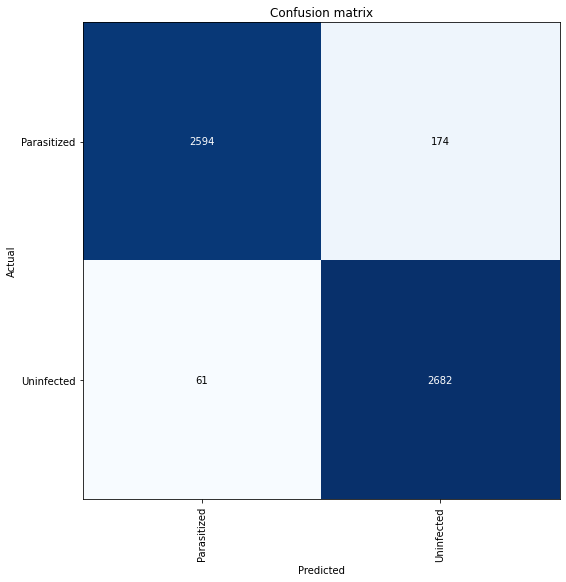

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,8))

Obtenemos las predicciones y utilizamos el *.shape* para generar representaciones gráficas de cambios de forma, basadas en criterios de predicción.

In [16]:
preds, y_true=learn.get_preds()
y_true.shape, preds.shape

(torch.Size([5511]), torch.Size([5511, 2]))

In [17]:
y_true=y_true.numpy() 
preds=np.argmax(preds.numpy(), axis=-1)
y_true.shape, preds.shape

((5511,), (5511,))

### **Paso 7. Creando un informe de métricas**

Creamos un informe de texto que muestre las principales métricas de clasificación.

In [18]:
classes = list(data.vocab)
report = classification_report(y_true, preds, target_names=classes)
print(report)

              precision    recall  f1-score   support

 Parasitized       0.98      0.94      0.96      2768
  Uninfected       0.94      0.98      0.96      2743

    accuracy                           0.96      5511
   macro avg       0.96      0.96      0.96      5511
weighted avg       0.96      0.96      0.96      5511



### **Paso 8. Mostrando resultados**

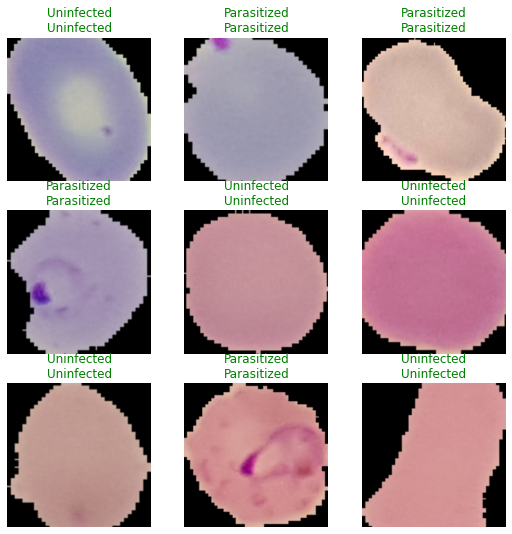

In [21]:
learn.show_results()